Loading and preprocessing dataset...
Training samples (normal only): 900
Testing samples (all): 1000

Training the autoencoder...
Epoch 1, Loss: 0.9486
Epoch 2, Loss: 0.9495
Epoch 3, Loss: 0.9284
Epoch 4, Loss: 0.9090
Epoch 5, Loss: 0.8828
Epoch 6, Loss: 0.8421
Epoch 7, Loss: 0.8041
Epoch 8, Loss: 0.7681
Epoch 9, Loss: 0.7364
Epoch 10, Loss: 0.7208
Epoch 11, Loss: 0.7194
Epoch 12, Loss: 0.6738
Epoch 13, Loss: 0.6462
Epoch 14, Loss: 0.6386
Epoch 15, Loss: 0.6256
Epoch 16, Loss: 0.6193
Epoch 17, Loss: 0.6207
Epoch 18, Loss: 0.6060
Epoch 19, Loss: 0.6050
Epoch 20, Loss: 0.5994
Epoch 21, Loss: 0.5828
Epoch 22, Loss: 0.5653
Epoch 23, Loss: 0.5496
Epoch 24, Loss: 0.5224
Epoch 25, Loss: 0.5164
Epoch 26, Loss: 0.4964
Epoch 27, Loss: 0.4784
Epoch 28, Loss: 0.4826
Epoch 29, Loss: 0.4708
Epoch 30, Loss: 0.4637
Training complete.

Detecting anomalies...
Anomaly threshold: 0.7670

--- Model Performance ---
Classification Report:
              precision    recall  f1-score   support

         0.0   

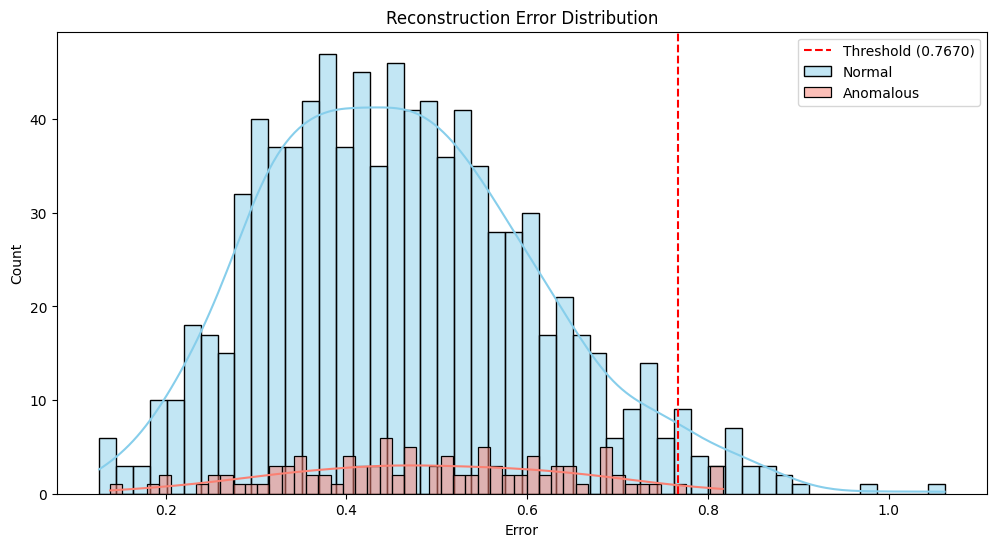

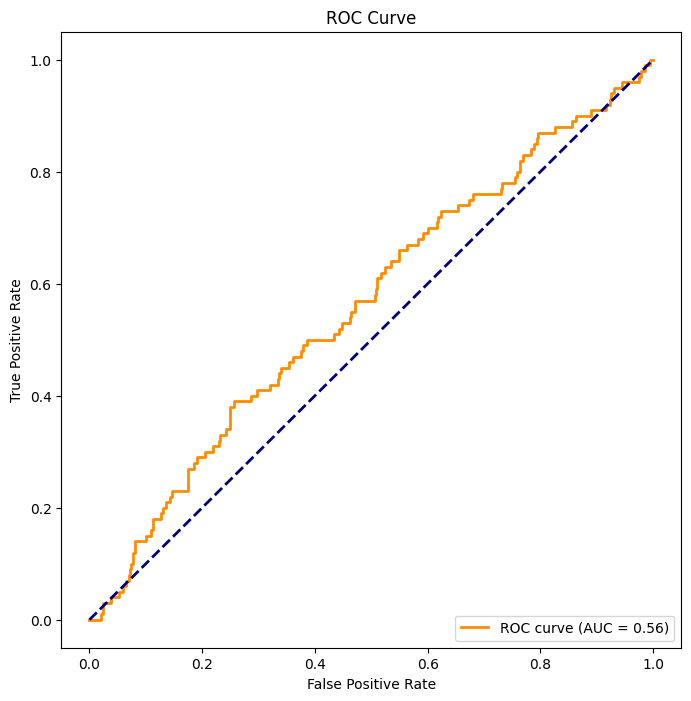

In [10]:
# ==============================================================================
# 0. Install Required Libraries (Uncomment if needed)
# ==============================================================================
# !pip install pandas numpy scikit-learn torch matplotlib seaborn requests

# ==============================================================================
# 1. Import Libraries
# ==============================================================================
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# ==============================================================================
# 2. Load and Preprocess Dataset
# ==============================================================================
print("Loading and preprocessing dataset...")

url = 'https://raw.githubusercontent.com/Professor-Marrah/AI_Network_Traffic_Anomaly_Detection/master/embedded_system_network_security_dataset.csv'
df = pd.read_csv(url)

# Check for missing values
df.dropna(inplace=True)

# Assume 'label' column exists: 0 = normal, 1 = anomaly
features = df.drop('label', axis=1)
labels = df['label']

# Scale features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Split data
X_train = scaled_features[labels == 0]  # train only on normal data
X_test = scaled_features
y_test = labels.values

# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# Create DataLoader
train_loader = DataLoader(TensorDataset(X_train_tensor), batch_size=64, shuffle=True)

print(f"Training samples (normal only): {X_train_tensor.shape[0]}")
print(f"Testing samples (all): {X_test_tensor.shape[0]}")

# ==============================================================================
# 3. Define Autoencoder Model
# ==============================================================================
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8)
        )
        self.decoder = nn.Sequential(
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, input_dim)
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))

model = Autoencoder(X_train_tensor.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# ==============================================================================
# 4. Train the Autoencoder
# ==============================================================================
print("\nTraining the autoencoder...")
epochs = 30
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        inputs, = batch
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")
print("Training complete.")

# ==============================================================================
# 5. Detect Anomalies
# ==============================================================================
print("\nDetecting anomalies...")
model.eval()
with torch.no_grad():
    reconstructions = model(X_test_tensor)
    errors = torch.mean((reconstructions - X_test_tensor)**2, dim=1).numpy()

threshold = np.mean(errors) + 2 * np.std(errors)
print(f"Anomaly threshold: {threshold:.4f}")
y_pred = (errors > threshold).astype(int)

# ==============================================================================
# 6. Evaluate Performance
# ==============================================================================
print("\n--- Model Performance ---")
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# ==============================================================================
# 7. Visualize Results
# ==============================================================================
plt.figure(figsize=(12, 6))
sns.histplot(errors[y_test == 0], bins=50, kde=True, color='skyblue', label='Normal')
sns.histplot(errors[y_test == 1], bins=50, kde=True, color='salmon', label='Anomalous')
plt.axvline(x=threshold, color='red', linestyle='--', label=f'Threshold ({threshold:.4f})')
plt.title('Reconstruction Error Distribution')
plt.xlabel('Error')
plt.ylabel('Count')
plt.legend()
plt.show()

fpr, tpr, _ = roc_curve(y_test, errors)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()
